In [1]:
import sys
sys.path.append('../Data_Feature')
sys.path.append('../Data_processing')
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, LeaveOneOut, train_test_split, cross_val_predict, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, matthews_corrcoef, make_scorer, confusion_matrix
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
from data_processing import KOProcessor 
import networkx as nx
from pyvis.network import Network
from bioservices import KEGG
import multiprocessing
import warnings
import logging

C:\Users\eliah\AppData\Local\Temp\ipykernel_30468\2941260958.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


c:\Users\eliah\Documents\Master\Eliah-Masters\Pipelines


In [ ]:
# Load and preprocess data
terms_zip_path = 'C:/Users/eliah/Documents/Master/Eliah-Masters/Datasets/terms_KO.zip'
terms_csv_path = 'terms_KO.csv'
traits_reduced_zip_path = 'C:/Users/eliah/Documents/Master/Eliah-Masters/Datasets/reducedDataset.zip'
traits_reduced_csv_path = 'reducedDataset.csv'
traits_assembled_zip_path = 'C:/Users/eliah/Documents/Master/Eliah-Masters/Datasets/assembledDataset.zip'
traits_assembled_csv_path = 'assembledDataset.csv'

processor = KOProcessor(
    terms_zip_path, 
    terms_csv_path, 
    traits_reduced_zip_path, 
    traits_reduced_csv_path, 
    traits_assembled_zip_path=traits_assembled_zip_path, 
    traits_assembled_csv_path=traits_assembled_csv_path
)

# Load and preprocess KO terms and traits
target_trait = "oxygen"

ko_terms = processor.load_terms()
if ko_terms is None:
        raise FileNotFoundError("KO terms could not be loaded. Please check the file paths.")

reduced_traits_data = processor.load_reduced_traits_data()
if reduced_traits_data is None:
    raise FileNotFoundError("Reduced traits data could not be loaded. Please check the file paths.")

# Debug: Print columns of reduced_traits_data
print("Columns in reduced_traits_data:", reduced_traits_data.columns.tolist())

# Uses assembled dataset if data not in reduced
traits_assembled = processor.load_assembled_traits_data()
if traits_assembled is not None:
    print("Columns in assembled_traits_data:", traits_assembled.columns.tolist())

#Feature_preprocess = processor.preprocess_features(ko_terms,reduced_traits_data)

# Preprocess KO terms and traits (trophy, gram, oxygen)
X_terms = processor.preprocess_terms(ko_terms)
y_traits = processor.preprocess_traits(reduced_traits_data, trait_column=target_trait, use_assembled_if_missing=True)

# Check if y_traits was processed correctly
if y_traits is None:
    raise ValueError(f"Traits data for {target_trait} could not be processed. Please check the log for errors.")

# Align features and labels
X_aligned, Y_aligned = processor.align_data(X_terms, y_traits)

# Feature Selection: Variance Threshold
selector = VarianceThreshold(threshold=0.01)
X_aligned = selector.fit_transform(X_aligned)

Data loaded successfully:
   Unnamed: 0   key      KO
0           0  1000  K00001
1           1  1000  K13954
2           2  1000  K00003
3           3  1000  K00013
4           4  1000  K00014
Data loaded successfully:
   key        ID                      speciesStrain  \
0    1  592010.0   Abiotrophia defectiva ATCC 49176   
1    1     219.0     Abiotrophia defectiva DSM 9849   
2    2  159837.0       Abyssibacter profundi OUC007   
3    3       NaN  Acanthopleuribacter pedis FYK2218   
4    4  258515.0   Acetanaerobacterium elongatum Z7   

                 speciesStrainComp                genus            genusComp  \
0    abiotrophiadefectivaatcc49176          Abiotrophia          abiotrophia   
1      abiotrophiadefectivadsm9849          Abiotrophia          abiotrophia   
2       abyssibacterprofundiouc007         Abyssibacter         abyssibacter   
3  acanthopleuribacterpedisfyk2218  Acanthopleuribacter  acanthopleuribacter   
4   acetanaerobacteriumelongatumz7  Acetanaerobac

In [ ]:
X_aligned

2025-03-06 16:47:46,720 - INFO - Processing trait: gram
2025-03-06 16:47:46,742 - INFO - Data split: 408 training samples, 175 test samples.
2025-03-06 16:47:46,744 - INFO - Starting grid search with StratifiedKFold CV on the training set.
C:\Users\eliah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(


Fitting 10 folds for each of 315 candidates, totalling 3150 fits


2025-03-06 16:48:43,912 - INFO - Best parameters for gram: {'estimator': RandomForestClassifier(random_state=42), 'estimator__max_depth': 5, 'estimator__n_estimators': 100, 'select_k__k': 200}
2025-03-06 16:48:43,913 - INFO - Best CV score for gram: 0.963
2025-03-06 16:48:43,922 - INFO - Test Set Evaluation - MCC: 0.953, F1 Score: 0.654


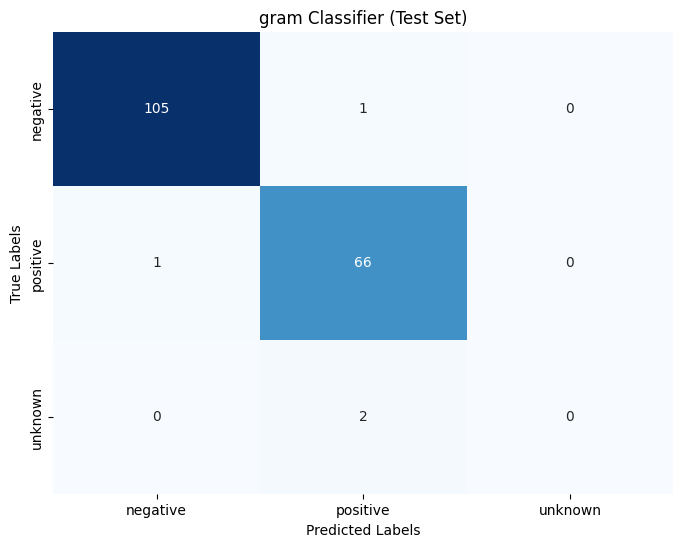

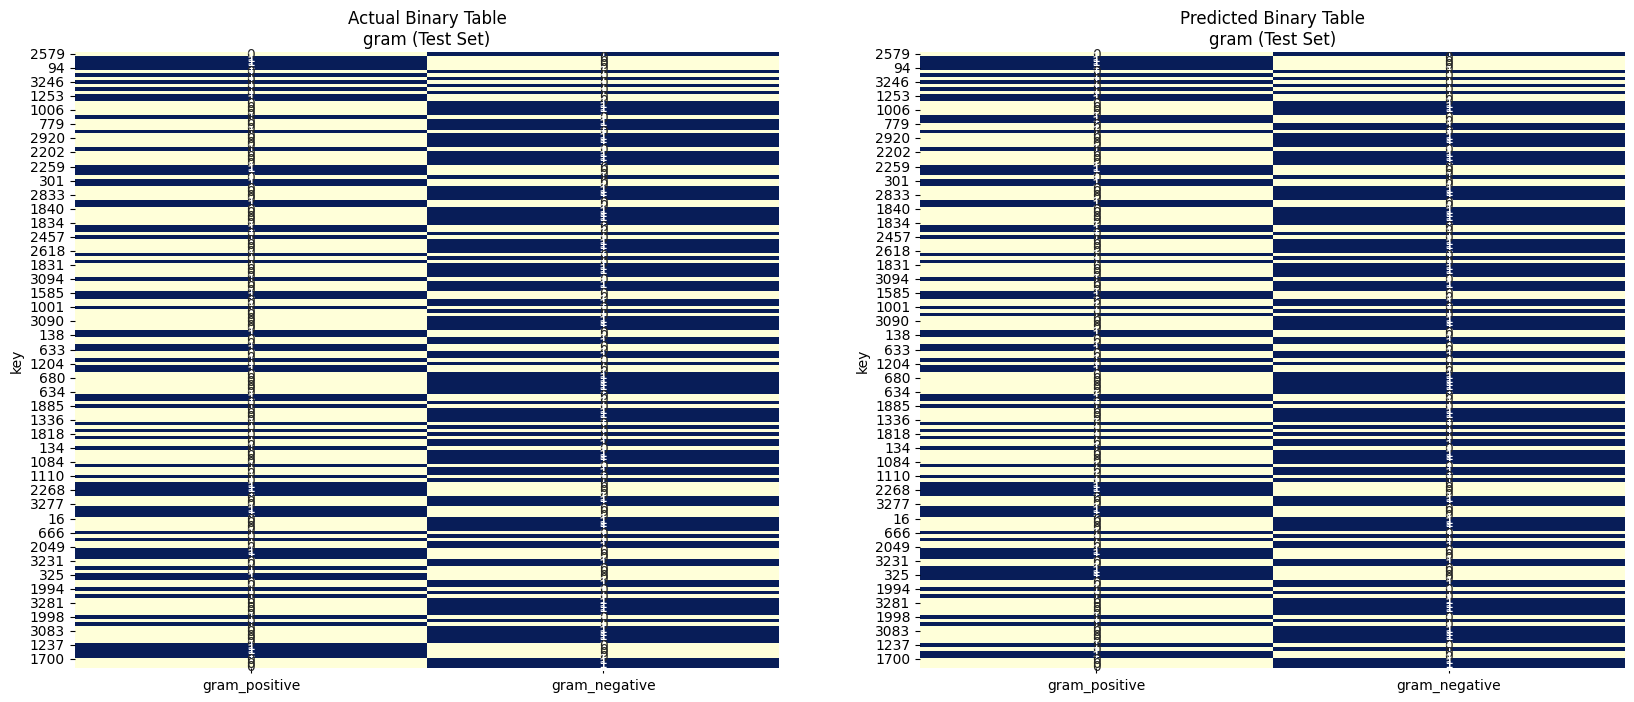

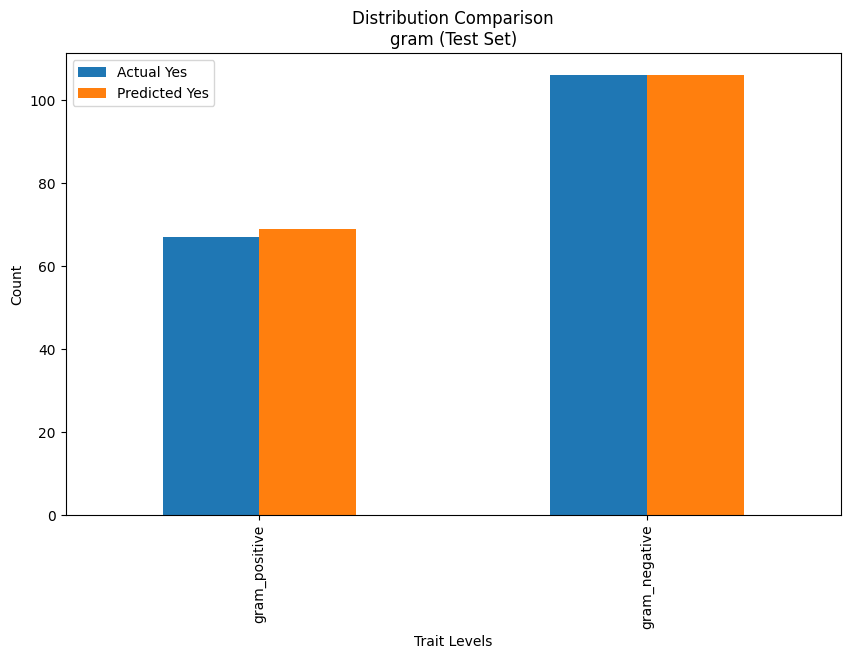

In [ ]:
#############################################
# STRATIFIED K-FOLD PIPELINE
#############################################

# Configure logging to include timestamps and log levels
logging.basicConfig(level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')

#############################################
# Helper Function: Binary Table Creation
#############################################

def create_binary_trait_table(trait_series, trait_name, trait_levels, delimiter=","):
    """
    Converts a trait Series into a binary DataFrame with one column per trait level.
    For each sample, each column is assigned 1 (Yes) if that level is present and 0 (No) otherwise.
    Works even if the trait contains multiple levels in a single string.
    """
    binary_df = pd.DataFrame(index=trait_series.index)
    for level in trait_levels:
        col_name = f"{trait_name}_{level}"
        def check_level(x):
            if pd.isnull(x):
                return 0
            if isinstance(x, list):
                return 1 if level in x else 0
            parts = [p.strip() for p in str(x).split(delimiter)]
            return 1 if level in parts else 0
        binary_df[col_name] = trait_series.apply(check_level)
    return binary_df

#############################################
# Post-Prediction Visualization Functions
#############################################

def plot_confusion_matrix(cm, title, class_labels):
    """Plots a heatmap of the confusion matrix with correct labels."""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()


def plot_side_by_side_comparison(actual_binary, predicted_binary, title):
    """Displays a side-by-side heatmap comparison of actual vs. predicted binary trait tables."""
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    sns.heatmap(actual_binary, annot=True, fmt="d", cmap='YlGnBu', cbar=False, ax=axes[0])
    axes[0].set_title("Actual Binary Table\n" + title)
    sns.heatmap(predicted_binary, annot=True, fmt="d", cmap='YlGnBu', cbar=False, ax=axes[1])
    axes[1].set_title("Predicted Binary Table\n" + title)
    plt.show()

def plot_distribution_comparison(actual_binary, predicted_binary, title):
    """Creates a grouped bar chart comparing the distribution (Yes counts) of actual vs. predicted values."""
    actual_counts = {col: actual_binary[col].sum() for col in actual_binary.columns}
    predicted_counts = {col: predicted_binary[col].sum() for col in predicted_binary.columns}
    dist_df = pd.DataFrame({
        'Actual Yes': pd.Series(actual_counts),
        'Predicted Yes': pd.Series(predicted_counts)
    })
    dist_df.plot(kind='bar', figsize=(10, 6))
    plt.title("Distribution Comparison\n" + title)
    plt.xlabel("Trait Levels")
    plt.ylabel("Count")
    plt.show()



#############################################
# Integrated Pipeline with Independent Test Set Using StratifiedKFold
#############################################

def train_and_evaluate_with_test_set(X_aligned, Y_aligned, target_trait, trait_levels, test_size=0.3, random_state=42):
    results = {}
    logging.info(f"Processing trait: {target_trait}")
    
    # Ensure Y_aligned is a pandas Series
    if not isinstance(Y_aligned, pd.Series):
        Y_aligned = pd.Series(Y_aligned, index=X_aligned.index)
    
    # Split the data into training and test sets (using stratification)
    X_train, X_test, Y_train, Y_test = train_test_split(
        X_aligned, Y_aligned, test_size=test_size, random_state=random_state, stratify=Y_aligned
    )
    logging.info(f"Data split: {X_train.shape[0]} training samples, {X_test.shape[0]} test samples.")
    
    # Build Binary Table for Test Set (for later comparison)
    actual_binary_test = create_binary_trait_table(Y_test, target_trait, trait_levels)
    
    # Main ML Pipeline with Grid Search on Training Set
    pipeline = Pipeline([
        ('select_k', SelectKBest(f_classif)),
        ('estimator', RandomForestClassifier())
    ])
    
    param_grid = [
    {
        'select_k__k': [10, 50, 100, 200, 300, 500, 1000],  
        'estimator': [RandomForestClassifier(random_state=42, class_weight='balanced')],
        'estimator__n_estimators': [100, 200, 300],  
        'estimator__max_depth': [5, 10, 15, None]  
    },
    {
        'select_k__k': [10, 50, 100, 200, 300, 500, 1000],  
        'estimator': [SVC(random_state=42)],
        'estimator__C': [0.1, 1, 10],  
        'estimator__kernel': ['linear', 'rbf'], 
        'estimator__gamma': ['scale', 'auto'],
        'estimator__class_weight': [None, 'balanced']
    },
    {
        'select_k__k' : [10, 50, 100, 200, 300, 500, 1000],
        'estimator': [LogisticRegression()],
        'estimator__C': [0.01, 0.1, 1, 10, 100]
    },         
    {
        'select_k__k': [10, 50, 100, 200, 300, 500, 1000],  
        'estimator': [BernoulliNB()],
        'estimator__alpha': [0.01, 0.1, 1.0, 10.0],  
        'estimator__binarize': [0.0]  # Is automatically applied
    }
]
    
    # Use StratifiedKFold CV (instead of Leave-One-Out) on the training set for grid search
    skf_train = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    logging.info("Starting grid search with StratifiedKFold CV on the training set.")
    grid_search = GridSearchCV(pipeline, param_grid, cv=skf_train, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, Y_train)
    
    logging.info(f"Best parameters for {target_trait}: {grid_search.best_params_}")
    logging.info(f"Best CV score for {target_trait}: {grid_search.best_score_:.3f}")
    
    best_model = grid_search.best_estimator_
    
    # Evaluate the final model on the independent test set
    Y_pred_test = best_model.predict(X_test)
    mcc_test = matthews_corrcoef(Y_test, Y_pred_test)
    f1_test = f1_score(Y_test, Y_pred_test, average='macro')
    logging.info(f"Test Set Evaluation - MCC: {mcc_test:.3f}, F1 Score: {f1_test:.3f}")
    
    # Plot test set evaluation results
    cm_test = confusion_matrix(Y_test, Y_pred_test)
    class_labels = sorted(list(set(Y_test) | set(Y_pred_test)))  # Get all unique class labels
    plot_confusion_matrix(cm_test, f"{target_trait} Classifier (Test Set)", class_labels)

    
    predicted_series_test = pd.Series(Y_pred_test, index=Y_test.index)
    predicted_binary_test = create_binary_trait_table(predicted_series_test, target_trait, trait_levels)
    
    plot_side_by_side_comparison(actual_binary_test, predicted_binary_test, f"{target_trait} (Test Set)")
    plot_distribution_comparison(actual_binary_test, predicted_binary_test, f"{target_trait} (Test Set)")
    
    return results

########################################
# Trait selection
########################################

# Oxygen:
target_trait = "oxygen"
trait_levels = ['aerobic', 'aerotolerant', 'microaerophilic', 'obligate_aerobic', 'anaerobic', 'obligate_anaerobic', 'conflict', 'facultative']

# Gramstain:
#target_trait = "gram"
#trait_levels = ['positive', 'negative']

# Trophy:
#target_trait = "trophy"
#trait_levels = ['photo', 'chemo', 'litho', 'hetero', 'organo', 'auto']

results = train_and_evaluate_with_test_set(X_aligned, Y_aligned, target_trait, trait_levels)


In [ ]:
#############################################
# LEAVE ONE OUT PIPELINE
#############################################

# Configure logging to include timestamps and log levels
logging.basicConfig(level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')

#############################################
# Helper Function: Binary Table Creation
#############################################

def create_binary_trait_table(trait_series, trait_name, trait_levels, delimiter=","):
    """
    Converts a trait Series into a binary DataFrame with one column per trait level.
    For each sample, each column is assigned 1 (Yes) if that level is present and 0 (No) otherwise.
    Works even if the trait contains multiple levels in a single string.
    """
    binary_df = pd.DataFrame(index=trait_series.index)
    for level in trait_levels:
        col_name = f"{trait_name}_{level}"
        def check_level(x):
            if pd.isnull(x):
                return 0
            if isinstance(x, list):
                return 1 if level in x else 0
            parts = [p.strip() for p in str(x).split(delimiter)]
            return 1 if level in parts else 0
        binary_df[col_name] = trait_series.apply(check_level)
    return binary_df

#############################################
# Post-Prediction Visualization Functions
#############################################

def plot_confusion_matrix(cm, title, class_labels):
    """Plots a heatmap of the confusion matrix with correct labels."""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()


def plot_side_by_side_comparison(actual_binary, predicted_binary, title):
    """Displays a side-by-side heatmap comparison of actual vs. predicted binary trait tables."""
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    sns.heatmap(actual_binary, annot=True, fmt="d", cmap='YlGnBu', cbar=False, ax=axes[0])
    axes[0].set_title("Actual Binary Table\n" + title)
    sns.heatmap(predicted_binary, annot=True, fmt="d", cmap='YlGnBu', cbar=False, ax=axes[1])
    axes[1].set_title("Predicted Binary Table\n" + title)
    plt.show()

def plot_distribution_comparison(actual_binary, predicted_binary, title):
    """Creates a grouped bar chart comparing the distribution (Yes counts) of actual vs. predicted values."""
    actual_counts = {col: actual_binary[col].sum() for col in actual_binary.columns}
    predicted_counts = {col: predicted_binary[col].sum() for col in predicted_binary.columns}
    dist_df = pd.DataFrame({
        'Actual Yes': pd.Series(actual_counts),
        'Predicted Yes': pd.Series(predicted_counts)
    })
    dist_df.plot(kind='bar', figsize=(10, 6))
    plt.title("Distribution Comparison\n" + title)
    plt.xlabel("Trait Levels")
    plt.ylabel("Count")
    plt.show()

def train_and_evaluate_with_test_set(X_aligned, Y_aligned, target_trait, trait_levels, test_size=0.3, random_state=42):
    results = {}
    logging.info(f"Processing trait: {target_trait}")
    
    # Ensure Y_aligned is a pandas Series
    if not isinstance(Y_aligned, pd.Series):
        Y_aligned = pd.Series(Y_aligned, index=X_aligned.index)
    
    # Split the data into training and test sets (using stratification)
    X_train, X_test, Y_train, Y_test = train_test_split(
        X_aligned, Y_aligned, test_size=test_size, random_state=random_state, stratify=Y_aligned
    )
    logging.info(f"Data split: {X_train.shape[0]} training samples, {X_test.shape[0]} test samples.")
    
    # --- Build Binary Table for Test Set (for later comparison) ---
    actual_binary_test = create_binary_trait_table(Y_test, target_trait, trait_levels)
    
    # --- Main ML Pipeline with Grid Search on Training Set ---
    pipeline = Pipeline([
        ('select_k', SelectKBest(f_classif)),
        ('estimator', RandomForestClassifier(random_state=random_state))
    ])
    
    param_grid = [
        {
            'select_k__k': [10, 50, 100, 200, 300, 500, 1000],
            'estimator': [RandomForestClassifier(random_state=random_state, class_weight='balanced')], # Add class balancing when using oxygen ass levels are unbalanced
            'estimator__n_estimators': [100, 200],
            'estimator__max_depth': [5, 10, None]
        },
        {
            'select_k__k': [10, 50, 100, 200, 300, 500, 1000],
            'estimator': [SVC(random_state=random_state)],
            'estimator__C': [0.1, 1, 10],
            'estimator__kernel': ['linear', 'rbf'],
            'estimator__gamma': ['scale', 'auto']
        },
        {
            'select_k__k': [10, 50, 100, 200, 300, 500, 1000],
            'estimator': [LogisticRegression(max_iter=1000, random_state=random_state)],
            'estimator__C': [0.01, 0.1, 1, 10, 100]
        },
        {
            'select_k__k': [10, 50, 100, 200, 300, 500, 1000],
            'estimator': [BernoulliNB()],
            'estimator__alpha': [0.01, 0.1, 1.0, 10.0],
            'estimator__binarize': [0.0]
        }
    ]
    
    # Use Leave-One-Out CV on the training set for grid search
    loo_train = LeaveOneOut()
    logging.info("Starting grid search with Leave-One-Out CV on the training set.")
    grid_search = GridSearchCV(pipeline, param_grid, cv=loo_train, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, Y_train)
    
    logging.info(f"Best parameters for {target_trait}: {grid_search.best_params_}")
    logging.info(f"Best CV score for {target_trait}: {grid_search.best_score_:.3f}")
    
    best_model = grid_search.best_estimator_
    
    # --- Evaluate the Final Model on the Independent Test Set ---
    Y_pred_test = best_model.predict(X_test)
    mcc_test = matthews_corrcoef(Y_test, Y_pred_test)
    f1_test = f1_score(Y_test, Y_pred_test, average='macro')
    logging.info(f"Test Set Evaluation - MCC: {mcc_test:.3f}, F1 Score: {f1_test:.3f}")
    
    # Plot test set evaluation results
    cm_test = confusion_matrix(Y_test, Y_pred_test)
    class_labels = sorted(list(set(Y_test) | set(Y_pred_test)))  # Get all unique class labels
    plot_confusion_matrix(cm_test, f"{target_trait} Classifier (Test Set)", class_labels)
    
    # Create binary table for predicted test labels and compare with actual
    predicted_series_test = pd.Series(Y_pred_test, index=Y_test.index)
    predicted_binary_test = create_binary_trait_table(predicted_series_test, target_trait, trait_levels)
    
    plot_side_by_side_comparison(actual_binary_test, predicted_binary_test, f"{target_trait} (Test Set)")
    plot_distribution_comparison(actual_binary_test, predicted_binary_test, f"{target_trait} (Test Set)")
    
    return results

#######################
# Trait selection
#######################

# Oxygen:
#target_trait = "oxygen"
#trait_levels = ['aerobic', 'aerotolerant', 'microaerophilic', 'obligate_aerobic', 'anaerobic', 'obligate_anaerobic', 'conflict', 'facultative']

# Gramstain:
target_trait = "gram"
trait_levels = ['positive', 'negative']

# Trophy:
#target_trait = "trophy"
#trait_levels = ['photo', 'chemo', 'litho', 'hetero', 'organo', 'auto']

results = train_and_evaluate_with_test_set(X_aligned, Y_aligned, target_trait, trait_levels)

In [7]:
#####################################
# CM_Plots
#####################################

# Define classifiers already used in pipeline
CLASSIFIERS = {
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42),
    "SVM": SVC(kernel="rbf", C=1, probability=True, random_state=42),
    "Logistic Regression": LogisticRegression(C=1, max_iter=500, random_state=42),
    "Naive Bayes": BernoulliNB(alpha=1.0, binarize=0.0)
}

def plot_multi_confusion_matrices(X_train, X_test, Y_train, Y_test, trait_name, trait_levels):
    """
    Trains the classifiers from the pipeline and plots confusion matrices.
    """
    logging.info(f"Generating confusion matrices for trait: {trait_name}")

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2x2 layout for 4 classifiers
    axes = axes.ravel()

    for idx, (name, clf) in enumerate(CLASSIFIERS.items()):
        logging.info(f"Training {name} classifier...")
        clf.fit(X_train, Y_train)
        Y_pred = clf.predict(X_test)

        cm = confusion_matrix(Y_test, Y_pred, labels=trait_levels)
        cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Normalize by row

        sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues", cbar=False,
                    xticklabels=trait_levels, yticklabels=trait_levels, ax=axes[idx])
        axes[idx].set_title(name)
        axes[idx].set_xlabel("Predicted")
        axes[idx].set_ylabel("True")

    plt.tight_layout()
    plt.show()

# Call function using the same dataset split from train_and_evaluate_with_test_set
plot_multi_confusion_matrices(X_train, X_test, Y_train, Y_test, target_trait, trait_levels)


NameError: name 'X_train' is not defined

In [ ]:
###############################
# MCC Vs. F1 Plot
###############################



# Assume that X_train and Y_train have been defined in the previous cell from your independent test split.
# For example:
# X_train, X_test, Y_train, Y_test = train_test_split(...)

# Define the range of k values to explore (number of features to select)
k_values = range(1, 1000, 20)

# Define the estimators to compare
estimators = {
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'SupportVectorMachines': SVC(random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'BernoulliNB': BernoulliNB()
}

# Prepare a dictionary to store results (for both F1 and MCC scores)
results = {name: {'f1': [], 'mcc': []} for name in estimators}

# Initialize StratifiedKFold cross-validation with 5 splits on the training set
cv = StratifiedKFold(n_splits=5)

# Loop over each estimator and each k value
for name, estimator in estimators.items():
    print(f"Processing estimator: {name}")
    for k in k_values:
        print(f"  Testing with k = {k}")
        # Create a pipeline that selects k features and applies the estimator
        pipeline = Pipeline([
            ('select_k', SelectKBest(f_classif, k=k)),
            ('estimator', estimator)
        ])
        # Evaluate F1-score using cross-validation on the training set
        f1_scores = cross_val_score(
            pipeline, X_train, Y_train, cv=cv,
            scoring=make_scorer(f1_score, average='macro'),
            n_jobs=-1
        )
        results[name]['f1'].append(f1_scores.mean())
        
        # Evaluate MCC using cross-validation on the training set
        mcc_scores = cross_val_score(
            pipeline, X_train, Y_train, cv=cv,
            scoring=make_scorer(matthews_corrcoef),
            n_jobs=-1
        )
        results[name]['mcc'].append(mcc_scores.mean())

# For debugging: print out the results dictionary
print(results)

# Plot the results for each estimator for both F1 and MCC
fig, ax = plt.subplots(2, 1, figsize=(12, 16))

for name, scores in results.items():
    k_values_list = list(k_values)  # Convert range to list for indexing
    
    # F1 Score Plot
    finite_f1_scores = [score for score in scores['f1'] if np.isfinite(score)]
    finite_k_values_f1 = [k for k, score in zip(k_values_list, scores['f1']) if np.isfinite(score)]
    ax[0].plot(finite_k_values_f1, finite_f1_scores, marker='o', linestyle='-', label=name)
    
    # Annotate the highest F1 score for this estimator
    if finite_f1_scores:
        max_f1_score = max(finite_f1_scores)
        max_f1_index = finite_f1_scores.index(max_f1_score)
        best_k_f1 = finite_k_values_f1[max_f1_index]
        ax[0].annotate(f'{max_f1_score:.2f}', (best_k_f1, max_f1_score),
                       textcoords="offset points", xytext=(0,10), ha='center')
    
    # MCC Score Plot
    finite_mcc_scores = [score for score in scores['mcc'] if np.isfinite(score)]
    finite_k_values_mcc = [k for k, score in zip(k_values_list, scores['mcc']) if np.isfinite(score)]
    ax[1].plot(finite_k_values_mcc, finite_mcc_scores, marker='o', linestyle='-', label=name)
    
    # Annotate the highest MCC score for this estimator
    if finite_mcc_scores:
        max_mcc_score = max(finite_mcc_scores)
        max_mcc_index = finite_mcc_scores.index(max_mcc_score)
        best_k_mcc = finite_k_values_mcc[max_mcc_index]
        ax[1].annotate(f'{max_mcc_score:.2f}', (best_k_mcc, max_mcc_score),
                       textcoords="offset points", xytext=(0,10), ha='center')

# Customize the F1 plot
ax[0].set_title('F1 Score by Number of Selected Features (k) for Different Estimators (Training Set)')
ax[0].set_xlabel('Number of Features (k)')
ax[0].set_ylabel('F1 Score')
ax[0].legend()
ax[0].grid(True)

# Customize the MCC plot
ax[1].set_title('MCC Score by Number of Selected Features (k) for Different Estimators (Training Set)')
ax[1].set_xlabel('Number of Features (k)')
ax[1].set_ylabel('MCC Score')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# KEGG Pathway Mapping
def map_ko_to_pathways(ko_terms):
    kegg = KEGG()
    pathways = {}
    for ko in ko_terms:
        try:
            gene_links = kegg.link("pathway", ko)
            if gene_links:
                for entry in gene_links.strip().split("\n"):
                    split_entry = entry.split("\t")
                    if len(split_entry) >= 2:
                        ko_id, pathway_id = split_entry[0], split_entry[1]
                        if pathway_id not in pathways:
                            pathways[pathway_id] = set()
                        pathways[pathway_id].add(ko)
        except Exception as e:
            print(f"Error processing {ko}: {e}")
    return pathways

selected_important_features = X_terms.columns[selector.get_support()]
pathways = map_ko_to_pathways(selected_important_features)

# Creating the adjacency matrix with translated KO terms, including original KO term
translated_kos = {ko: f"Translated_{ko}" for ko in selected_important_features}  # Placeholder for actual translation function
pathway_matrix = pd.DataFrame(
    index=[f"{translated_kos[ko]} ({ko})" for ko in selected_important_features],
    columns=pathways.keys(),
    data=0
)
for pathway, kos in pathways.items():
    for ko in kos:
        if ko in selected_important_features:
            pathway_matrix.loc[f"{translated_kos[ko]} ({ko})", pathway] = 1

# Fetch and rename pathway names for readability
kegg = KEGG()
for column in pathway_matrix.columns:
    pathway_info = kegg.get(column)
    parsed_info = kegg.parse(pathway_info)
    pathway_name = parsed_info['NAME'][0] if 'NAME' in parsed_info else column
    pathway_matrix.rename(columns={column: pathway_name}, inplace=True)

print("Pathway matrix after renaming:\n", pathway_matrix)

# Heatmap visualization
sns.heatmap(pathway_matrix, annot=True, cmap="Greys", cbar=False)
plt.title(f'Adjacency Matrix of KO Terms and Pathways ({trait_column})')
plt.xlabel('Pathways')
plt.ylabel('KO Terms')
plt.show()

# Network Visualization
G = nx.Graph()

# Define a list of general pathways to exclude
excluded_pathways = ["metabolic pathways"]  # You can add more general terms here

# Add nodes and edges with renamed pathway names
for ko in selected_important_features:
    translated_label = f"{translated_kos[ko]} ({ko})"
    G.add_node(ko, title=translated_label, label=translated_label, color='red', size=20)

for pathway_id, kos in pathways.items():
    pathway_info = kegg.get(pathway_id)
    parsed_info = kegg.parse(pathway_info)
    pathway_name = parsed_info['NAME'][0] if 'NAME' in parsed_info else pathway_id
    if pathway_name.lower() not in excluded_pathways:
        G.add_node(pathway_name, title=pathway_name, label=pathway_name, color='blue', size=30)
        for ko in kos:
            G.add_edge(ko, pathway_name)

# Pyvis network visualization
nt = Network("800px", "1200px", notebook=True, heading=f'Interactive Network of KO Terms and Pathways ({trait_column})', bgcolor="#ffffff", font_color="black", cdn_resources='remote')
nt.from_nx(G)
nt.toggle_physics(True)
nt.show_buttons(filter_=['physics'])
nt.save_graph(f"ko_network_{trait_column}.html")
